<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic3/3.4_RAPTOR_demo_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# 3.4. RAPTOR demo

**By: [Alexander Rubinstein](https://www.linkedin.com/in/alexander-rubinstein-043564116/)**

The code is based on: https://github.com/parthsarthi03/raptor.

# Introduction

As we learned in the long read about hallucinations in retrieval augmented language models (RALMs), suboptimal document granularity can degrade model performance.

In this notebook, we will conduct a case study examining this issue and reimplement a solution called [RAPTOR](https://arxiv.org/abs/2401.18059) (Retrieval Augmented Prompt Optimization and Tree-based Organization for RAG).

In the following sections we will:

- Prepare the environment and utility functions ([Getting things ready](#getting-things-ready), [Imports + Constants](#imports-+-constants), [Utility functions](#utility-functions)),
- Setup all the needed local variables ([Load keys](#load-keys), [Make Nebius client](#make-nebius-client), [Prepare documents](#prepare-documents) and [Prepare db with original docs](#prepare-db-with-original-docs)).
- Check how standard retrieval augmented generation (RAG) fails to answer a question based on the documents from the retrieval database ([Standard RAG](#standard-rag)) because of the suboptimal documents granularity.
- Reimplement [RAPTOR](https://arxiv.org/abs/2401.18059) to address the issue ([Raptor-based RAG](#raptor-based-rag)).

# Getting things ready

In this section we install all the needed libraries.

In [ ]:
# takes ~3 min in colab
!pip install -q annotated-types==0.7.0 anyio==4.8.0 appnope  asttokens  beautifulsoup4==4.13.3 certifi==2025.1.31 charset-normalizer==3.4.1 click==8.1.8 comm  contourpy==1.3.1 cycler==0.12.1 debugpy  decorator  deprecation==2.1.0 distro==1.9.0 exceptiongroup  executing  faiss-cpu==1.10.0 filelock==3.18.0 fonttools==4.56.0 fsspec==2025.3.2 gdown==5.2.0 h11==0.14.0 httpcore==1.0.7 httpx==0.28.1 huggingface-hub==0.27.0 idna==3.10 importlib_metadata  ipykernel  ipython  jedi  Jinja2==3.1.6 jiter==0.9.0 joblib==1.4.2 jsonpatch==1.33 jsonpointer==3.0.0 jupyter_client  jupyter_core  kiwisolver==1.4.8 lancedb==0.21.1 langchain-core==0.3.58 langchain-text-splitters==0.3.8 langsmith==0.3.15 llvmlite==0.43.0 MarkupSafe==3.0.2 matplotlib==3.10.1 matplotlib-inline  mpmath==1.3.0 nest_asyncio  networkx==3.4.2 nltk==3.9.1 numba==0.60.0 numpy==2.0.0 openai==1.82.0 orjson==3.10.15 overrides==7.7.0 packaging  pandas==2.2.2 parso  pexpect  pickleshare  pillow==11.1.0 platformdirs  prompt_toolkit  psutil  ptyprocess  pure_eval  pyarrow==19.0.1 pydantic==2.10.6 pydantic_core==2.27.2 Pygments  pylance==0.24.1 pynndescent==0.5.13 pyparsing==3.2.1 PySocks==1.7.1 python-dateutil  pytz==2025.2 PyYAML==6.0.2 pyzmq  regex==2024.11.6 requests==2.32.3 requests-toolbelt==1.0.0 safetensors==0.5.3 scikit-learn==1.6.1 scipy==1.15.2 sentence-transformers==2.2.2 sentencepiece==0.2.0 six  sniffio==1.3.1 soupsieve==2.6 stack_data  sympy==1.13.1 tenacity==8.2.3 threadpoolctl==3.6.0 tiktoken==0.5.1 tokenizers==0.15.2 torch==2.6.0 torchvision==0.21.0 tornado  tqdm==4.67.1 traitlets  transformers==4.38.1 typing_extensions  tzdata==2025.2 umap-learn==0.5.5 urllib3==1.26.11 wcwidth  zipp  zstandard==0.23.0

# Imports + Constants

In this section we perform import of all the needed libraries.

In [ ]:
%reload_ext autoreload
%autoreload 2


import os
import gdown
import torch
import torch
from huggingface_hub import login
import numpy as np
import random
import logging
import tiktoken
from typing import (
    Callable,
    List,
    Optional,
    Set
)
from openai import OpenAI
import shutil
from langchain_text_splitters import RecursiveCharacterTextSplitter
import numpy as np
import os
from typing import List
from tqdm import tqdm
import warnings

# for lancedb
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from pydantic import Field

# for clustering
from sklearn.mixture import GaussianMixture
import umap


# Suppress all warnings
warnings.filterwarnings('ignore')


PATH_TO_RAPTOR = "./raptor"
RANDOM_SEED = 42
SAMPLE_TEXT_PATH = os.path.join('docs', 'sample.txt')
GRANULARITY = 100
SUMMARY_LENGTH = 200
TEMPERATURE = 0.0 # for deterministic output
EMBED_MODEL_NAME = "BAAI/bge-small-en-v1.5"
EMBED_MODEL = get_registry().get("huggingface").create(name=EMBED_MODEL_NAME)
SUMMARIZATION_MODEL = "google/gemma-2-2b-it"
TOKENIZER_NAME = "cl100k_base"
QUESTION = "Was the pigeon disease harmful and what was the cause of it?"
TOP_K = 1
ANSWERING_MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
MAX_LENGTH_TO_SUMMARIZE = 1024
MAX_SUMMARIZATION_LENGTH = 50
# takes ~1 min in colab

# Utility functions

Here, we define utility functions used throughout the notebook, including text processing and the `answer_with_rag` function.

In [ ]:
def format_text(text):
    """
    Formats and normalizes text by removing punctuation and special characters, then splits it into lines of a fixed width.

    This function performs the following transformations:
    1. Removes all newlines (\n), carriage returns (\r), and tabs (\t)
    2. Removes punctuation marks (., ?, !, ,, ;, :)
    3. Strips leading and trailing whitespace
    4. Splits the text into lines of approximately 80 characters while preserving word boundaries

    Args:
        text (str): The input text to be formatted

    Returns:
        str: The formatted text with:
            - All punctuation and special characters removed
            - Text split into lines of ~80 characters
            - Lines joined with newline characters

    Example:
        >>> text = "Hello, world!\nHow are you?"
        >>> format_text(text)
        'Hello world How are you'
    """
    text = (text
        .replace("\n", "")
        .replace("\r", "")
        .replace("\t", "")
        .replace(".", "")
        .replace("?", "")
        .replace("!", "")
        .replace(",", "")
        .replace(";", "")
        .replace(":", "")
        .strip()
    )
    # Split text into chunks of 80 characters, keeping words together
    lines = insert_newlines(text)

    return '\n'.join(lines)


def insert_newlines(text, line_length=80):
    """
    Splits a text string into lines of specified maximum length while preserving word boundaries.

    This function takes a string of text and splits it into multiple lines, ensuring that:
    1. No line exceeds the specified maximum length
    2. Words are not split across lines
    3. Lines are space-separated

    Args:
        text (str): The input text to be split into lines
        line_length (int, optional): Maximum length for each line. Defaults to 80 characters.

    Returns:
        list[str]: A list of strings, where each string is a line of text that:
            - Does not exceed line_length characters
            - Contains complete words only
            - Has words separated by single spaces

    Example:
        >>> text = "This is a very long text that needs to be split into multiple lines"
        >>> insert_newlines(text, line_length=20)
        ['This is a very long', 'text that needs to', 'be split into', 'multiple lines']
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) + (1 if current_line else 0) <= line_length:
            if current_line:
                current_length += 1  # Account for space
            current_line.append(word)
            current_length += len(word)
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)

    if current_line:
        lines.append(' '.join(current_line))
    return lines


def apply_random_seed(random_seed):
    """
    Sets random seeds for multiple Python libraries to ensure reproducibility.

    This function sets consistent random seeds across different libraries and components:
    1. Python's random module
    2. NumPy
    3. PyTorch (CPU and CUDA)
    4. CUDA backend configurations

    Args:
        random_seed (int): The seed value to be used across all random number generators

    Side Effects:
        - Sets random seeds for multiple libraries
        - Configures PyTorch's CUDA backend for deterministic operation
        - Sets environment variable for CUDA
        - Enables deterministic algorithms in PyTorch

    Note:
        This function is crucial for reproducible machine learning experiments
        as it ensures consistent random number generation across all components.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # to suppress warning
    torch.use_deterministic_algorithms(True, warn_only=True)


def search_table(table, query, where=None, limit=5):
    """
    Performs a search operation on a database table with optional filtering.

    This function searches a database table using a query string and converts
    the results to a specified schema format.

    Args:
        table: The database table to search in
        query (str): The search query string
        where (str, optional): SQL-style WHERE clause for filtering results. Defaults to None
        limit (int, optional): Maximum number of results to return. Defaults to 5

    Returns:
        list[BasicSchema]: A list of search results converted to BasicSchema format,
            limited to the specified number of records

    Note:
        The function uses prefiltering when a where clause is provided for
        optimized search performance.
    """
    search_result = table.search(query)
    if where is not None:
        search_result = search_result.where(where, prefilter=True)
    return search_result.limit(limit).to_pydantic(BasicSchema)


class BasicSchema(LanceModel):
    """
    Pydantic model defining the schema for storing data in the database.

    This schema defines the structure for storing and retrieving data, including
    embedded vectors for similarity search.

    Attributes:
        text (str): The source text field that will be embedded
        vector (Vector): The embedded vector representation of the text
        children (List[str]): List of reference IDs for hierarchical relationships
            E.g. can store IDs of original documents that were used to create
            each summary in RAPTOR pipeline, enabling RAPTOR to track relationships
            between summaries and source documents
        id (int): Unique identifier for the record

    Note:
        The vector dimension is determined by the EMBED_MODEL's output dimension
    """
    text: str = EMBED_MODEL.SourceField()
    vector: Vector(EMBED_MODEL.ndims()) = EMBED_MODEL.VectorField(default=None)
    children: List[str] = Field(default_factory=list)  # List of reference IDs
    id: int = Field(default_factory=int)


def search_result_to_context(search_result):
    """
    Converts search results into a concatenated context string.

    This function takes a list of search results and combines their text fields
    into a single string, with results separated by newlines.

    Args:
        search_result (list[BasicSchema]): List of search results to process

    Returns:
        str: A single string containing all result texts, separated by double newlines

    Example:
        >>> results = [BasicSchema(text="First result"), BasicSchema(text="Second result")]
        >>> search_result_to_context(results)
        'First result\n\nSecond result'
    """
    return "\n\n".join(
        [record.text for record in search_result]
    )


def prepare_context_maker_standard(lance_table, limit=TOP_K):
    """
    Creates a function for generating context from a database table.

    This is a factory function that returns another function specifically configured
    to generate context using standard search parameters.

    Args:
        lance_table: The database table to search in
        limit (int, optional): Maximum number of results to include in context.
            Defaults to TOP_K constant

    Returns:
        callable: A function that takes a query string and returns formatted context

    The returned function has the following signature:
        make_context_standard(query: str) -> str
    """
    def make_context_standard(query):
        return search_result_to_context(search_table(lance_table, query, limit=limit))
    return make_context_standard


def answer_with_rag(
    query,
    client,
    model_name,
    make_context,
    verbose=False,
):
    """
    Generates an answer to a query using Retrieval-Augmented Generation (RAG).

    This function implements the RAG pattern by:
    1. Retrieving relevant context using the provided context maker
    2. Combining the context with the query
    3. Getting a response from an LLM

    Args:
        query (str): The user's question to be answered
        client: The API client for the language model service
        model_name (str): The name/identifier of the language model to use
        make_context (callable): Function that generates context from the query
        verbose (bool, optional): If True, returns detailed results including context.
            Defaults to False

    Returns:
        Union[str, dict]: If verbose is False, returns just the model's answer.
            If verbose is True, returns a dictionary containing:
            - 'context': The retrieved context
            - 'answer': The model's response

    Side Effects:
        Prints the question, retrieved context, and answer to standard output
    """
    context = make_context(query)
    completion = client.chat.completions.create(
            messages=[
            {
                "role": "user",
                "content": f"""Leveraging the following context, answer the query.
                If you can't answer using the context, say that you don't know.
                Don't add any additional information words in that case.

                    CONTEXT:
                    {context}

                    QUERY:
                    {query}"""
                }
            ],
            model=model_name,
            temperature=TEMPERATURE,
            seed=RANDOM_SEED
            )

    if verbose:
        results = {
                "context": context,
                "answer": completion.choices[0].message.content
        }
    else:
        results = completion.choices[0].message.content

    print("Question:\n", query)
    print("--------------------------------")
    print("Retrieved context:\n", format_text(results["context"]))
    print("--------------------------------")
    print("Answer based on context:\n", results["answer"])
    return results

# Setup

In this section we define local variables used throughout the notebook.

## Load keys

Before running the following cells, please upload the Nebius AI Studio API key in a nebius_api_key file.

In [ ]:
from google.colab import files

uploaded = files.upload()

assert os.path.exists('nebius_api_key')

Saving nebius_api_key to nebius_api_key


First, we need to load the key for [Nebius AI studio](https://nebius.com/ai-studio). We will use this service to perform inference for large language models (LLMs) on cloud-based GPUs allowing to run this notebook on machines without GPUs.

In [ ]:
with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

## Make Nebius client

Second, we create client for [Nebius AI studio](https://nebius.com/ai-studio) mentioned in the previous markdown cell.

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

## Prepare documents

In this section we will prepare text by splitting it into documents of 100 tokens each. These documents will form our external database for RAG.

The text consists of 3 subtexts: the first one tells the story of a mysterious illness called "Pigeon's Blessing", the second one is an excerpt from an encyclopedia article about pigeons, and the last one describes the "Bless" spell from a video game. The text will be downloaded to the path `docs/sample.txt`.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",
    chunk_size=100,
    # chunk_size=50,
    chunk_overlap=0,
    separators=[".", "!", "?", "\n", ",", ";", ":"]
)

splitted_docs = []

if not os.path.exists(SAMPLE_TEXT_PATH):
    os.makedirs(os.path.dirname(SAMPLE_TEXT_PATH), exist_ok=True)
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=1_sE53mgV_RptRv8LXl4IPrAeruTfmw3-",
        SAMPLE_TEXT_PATH,
        quiet=True
    )

with open(SAMPLE_TEXT_PATH, "r") as f:
    text = f.read()
    docs = text_splitter.create_documents([text])
    splitted_docs.extend([
        {
            "text": doc.page_content,
            "children": [],
            "id": i
        }
            for i, doc
                in enumerate(docs)
    ])

print("Total splits:", len(splitted_docs))
print("==First split:==\n", splitted_docs[0])
print("==Last split:==\n", splitted_docs[-1])

Total splits: 19
==First split:==
 {'text': 'In the quaint coastal town of Bellmare, a curious ailment known as "Pigeon Blessing" emerged seemingly overnight. Initially, townsfolk celebrated it, believing it to be a sign of good fortune—hence the unusual name. However, as cases multiplied, excitement turned to concern.\n\nThe first recorded case was Evelyn Carter, an elderly woman known locally for feeding pigeons in Bellmare\'s central plaza', 'children': [], 'id': 0}
==Last split:==
 {'text': '. With the exception of peasants; where +1 basically doubles their damage output. This boost could be a game changer in numbers massive enough. However, getting to that point is only reasonable on paper and even then, it is really hard to keep them alive.', 'children': [], 'id': 18}


## Prepare db with the original docs

Here, we convert text splitted into 19 documents to the vector database using [lancedb](https://lancedb.github.io/lancedb/) library.

In [ ]:
# This line is needed in case you've ran this cell before to clear the db dir
!rm -rf /tmp/lancedb

db = lancedb.connect("/tmp/lancedb")

lance_table = db.create_table(
    "transformer_docs",
    mode='overwrite',
    schema=BasicSchema
)

lance_table.add(
    splitted_docs,
    on_bad_vectors='drop'
)

# Standard RAG

## Answer with standard RAG

Let's try to answer a question based on the text in the retrieval database with standard RAG. For demonstration purposes we limit the size of the retrieved context to only one document throughout this notebook.

In [ ]:
make_context_standard = prepare_context_maker_standard(lance_table)
results = answer_with_rag(
    QUESTION,
    client=client,
    model_name=ANSWERING_MODEL_NAME,
    make_context=make_context_standard,
    verbose=True,
)

Question:
 Was the pigeon disease harmful and what was the cause of it?
--------------------------------
Retrieved context:
 Human interactions with pigeons are diverse ranging from historical uses such as
messenger birds and food sources to contemporary roles as indicators of urban
ecological healthIn modern urban environments pigeons are sometimes viewed
negatively due to their abundance and potential as disease vectors However
ongoing research continues to reveal the complexity of pigeon biology and
underscores their importance within ecosystems and human cultures worldwide
Pigeons are rarely considered as a blessing but rather as a nuisanceThe Bless
spell counters the Curse spell
--------------------------------
Answer based on context:
 I don't know.


As we can see, the model did not manage to answer the question, because the retrieved document only contained general information about pigeons, without mentioning any illnesses. Due to suboptimal document granularity, there was no single document that contained both words connected to "Pigeon Blessing" illness and its cause (you can check all the documents by changing parameters of print functions in the **Prepare documents** section or checking the cells in **Demonstrating suboptimal documents granularity**). As a result, the document with the highest cosine similarity to our query was irrelevant to answering our specific question.

To overcome this problem, let's implement [RAPTOR](https://arxiv.org/abs/2401.18059) (Retrieval Augmented Prompt Optimization and Tree-based Organization for RAG) - a retrieval method that addresses suboptimal document granularity in RAG by organizing documents into a hierarchical tree structure and performing recursive clustering.

# RAPTOR-based RAG

![RAPTOR Retrieval Process](https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/raptor_overview.png)

[RAPTOR](https://arxiv.org/abs/2401.18059) aims to solve the problem of suboptimal document granularity in RAG systems by organizing documents into a hierarchical structure. The method first clusters related documents together, creates summaries for each cluster, and adds these summaries to the retrieval database.

When retrieving documents, RAPTOR first searches among the cluster summaries to find relevant topics. For each relevant summary found, it then retrieves the most relevant original documents from that cluster. Finally, it combines both the summaries and original documents into the context for the language model.

This approach helps ensure that related information spread across multiple documents can be effectively retrieved and used together to answer queries.

To populate the database, we'll act in two steps:

- First, we'll create a recursive clustering of text chunks
- Then, we'll summarize chunks inside every cluster

## Step 1. Perform clustering

### Gausian mixture clustering

First, let's cluster document embeddings based on their similarity. Below we share an adapted version of the clustering used in the original paper using [Gaussian Mixture Models](https://www.youtube.com/watch?v=EWd1xRkyEog).

We'll give here a high-level overview of the clustering algorithm (please see "Clustering Algorithm" on page 3 in the Raptor paper for details).

The goal is to create a two-step hierarchy **corpus > clusters of text chunks > text chunks**, where the total length of each cluster (in tokens) is lower than some `max_length_in_cluster`. The latter that clusters remain manageable in size and maintain semantic coherence. Controlling the size is important, because on the next stage we'll be summarizing every cluster, and a too huge local cluster might be summarized poorly or, in some cases, even fail to fit into the LLM's context length.

Two main tools are used in the algorithm:

* **Dimensionality Reduction with UMAP**
   
  The code uses [**Uniform Manifold Approximation and Projection (UMAP)**](https://arxiv.org/abs/1802.03426) to reduce the high-dimensional embeddings into a lower-dimensional space. This reduction helps make clustering more computationally efficient and can help reveal underlying patterns.

  The UMAP algorithm relies on a graph of nearest neighbors with a crucial hyperparameter `n_neighbors` which is automatically calculated as a square root of total number of text chunks or as a predefined parameter of target embedding size `reduction_dimension`.

* Clustering using [**Gaussian Mixture Models (GMM)**](https://scikit-learn.org/stable/modules/mixture.html). The model is fit using Expectation-Maximization algorithm. Documents are assigned to clusters based on a probability threshold; a document can belong to multiple clusters if their probability exceeds the threshold.

  The optimal number of clusters is determined using [BIC (Bayesian Information Criterion)](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

The clustering is performed through the following recursive process:

1. Global dimension reduction and clustering.
    
    First, the initial embeddings are reduced by UMAP with target embedding size of `reduction_dimension` and `n_neighbors` equal  to the square root of total number of text chunks, and GMM clustering is applied to the resulting vectors. We'll refer to the clusters created as this stage as to global clusters.
    
    Now, if a global cluster's contains more chunks than dimensionality parameter `reduction_dimension`, this cluster is further subdivided through the local dimension reduction and clustering.
    
2. Local dimension reduction and clustering
    
    This is done independently for each large global cluster. First, the original embeddings are reduced by UMAP with target embedding size of `reduction_dimension` and `n_neighbors` equal `reduction_dimension`. Then, each global cluster is again subclustered with GMM.
    
3. Recursive clustering
    Finally, if the total token length of a local cluster exceeds `max_length_in_cluster`, the whole clustering process is recursively reapplied to its text chunks. This continues until all clusters have a total token length within the specified limit.

The key advantage of this approach is that it:
- Handles high-dimensional data efficiently through UMAP reduction
- Automatically determines the optimal number of clusters using BIC
- Handles large datasets efficiently by recursively subdividing clusters when their combined text length exceeds the model's token limit
- Allows for soft clustering (documents can belong to multiple clusters)
- The hierarchical clustering approach enables analysis at multiple levels, capturing both high-level topics and granular subject matter relationships.


In [ ]:
class Node:
    """
    Represents a node in the hierarchical tree structure.

    Attributes:
        text (str): The text content of the node
        index (int): Unique identifier for the node
        children (Set[int]): Set of indices of child nodes
        embeddings: Vector representation of the node's text content
        summarization_prompt (Optional[str]): Template for generating summaries of this node
    """

    def __init__(self, text: str, index: int, children: Set[int], embeddings, summarization_prompt: Optional[str] = None) -> None:
        self.text = text
        self.index = index
        self.children = children
        self.embeddings = embeddings
        self.summarization_prompt = summarization_prompt


def print_clusters(clusters):
    """
    Print the contents of document clusters in a formatted way.

    Args:
        clusters (List[List[Node]]): List of clusters, where each cluster is a list of Node objects
    """
    for i, cluster in enumerate(clusters):
        print()
        print(f"Cluster {i}:")
        for node in cluster:
            print(f"Node {node.index}: {format_text(node.text)}")
            print()
        print("--------------------------------")


def perform_recursive_clustering(
    lance_table: lancedb.table.LanceTable,
    cluster_func: Callable,
    max_length_in_cluster: int = 3500,
    tokenizer=tiktoken.get_encoding(TOKENIZER_NAME),
    reduction_dimension: int = 10,
    threshold: float = 0.1,
    verbose: bool = False,
    random_state: int = RANDOM_SEED,
) -> List[List[Node]]:
    """
    Recursively clusters documents into a hierarchical structure based on their embeddings.

    Args:
        lance_table (lancedb.table.LanceTable): Table containing document data
        cluster_func (Callable): Function to perform clustering
        max_length_in_cluster (int): Maximum total token length allowed in a single cluster
        tokenizer: Tokenizer instance for calculating text lengths
        reduction_dimension (int): Minimum number of nodes required to continue clustering
        threshold (float): Clustering probability threshold
        verbose (bool): Whether to print detailed logging information
        random_state (int): Random seed for reproducibility

    Returns:
        List[List[Node]]: List of clusters, where each cluster contains related Node objects
    """

    # Suppress all warnings for this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    df = lance_table.to_pandas()
    nodes = df_to_nodes(df)
    apply_random_seed(random_state)
    embeddings = np.array([node.embeddings for node in nodes])

    clusters = perform_clustering_impl(
        embeddings, reduction_dimension=reduction_dimension, threshold=threshold, random_state=random_state, cluster_func=cluster_func
    )

    node_clusters = []

    unique_labels = sorted(set(np.concatenate(clusters)))

    for label in unique_labels:
        indices = sorted([i for i, cluster in enumerate(clusters) if label in cluster])
        cluster_nodes = [nodes[i] for i in indices]

        if len(cluster_nodes) == 1:
            node_clusters.append(cluster_nodes)
            continue

        total_length = sum(
            [len(tokenizer.encode(node.text)) for node in cluster_nodes]
        )

        if total_length > max_length_in_cluster:
            if verbose:
                logging.info(
                    f"reclustering cluster with {len(cluster_nodes)} nodes"
                )
            node_clusters.extend(
                perform_recursive_clustering(
                    cluster_nodes,
                    cluster_func=cluster_func,
                    max_length_in_cluster=max_length_in_cluster,
                    tokenizer=tokenizer,
                    reduction_dimension=reduction_dimension,
                    threshold=threshold,
                    verbose=verbose,
                    random_state=random_state
                )
            )
        else:
            node_clusters.append(cluster_nodes)

    return node_clusters


def perform_clustering_impl(
    embeddings: np.ndarray,
    reduction_dimension: int,
    threshold: float,
    cluster_func: Callable,
    verbose: bool = False,
    random_state: int = RANDOM_SEED,
) -> List[np.ndarray]:
    """
    Implements two-level hierarchical clustering of document embeddings.

    Args:
        embeddings (np.ndarray): Document embedding vectors
        reduction_dimension (int): Dimension for embedding reduction
        threshold (float): Clustering probability threshold
        cluster_func (Callable): Function to perform clustering
        verbose (bool): Whether to print detailed logging information
        random_state (int): Random seed for reproducibility

    Returns:
        List[np.ndarray]: List of cluster assignments for each document
    """
    reduced_embeddings_global = global_cluster_embeddings(
        embeddings,
        min(reduction_dimension, len(embeddings) -2),
        random_state=random_state,
        n_neighbors=int((len(embeddings) - 1) ** 0.5)
    )
    global_clusters, n_global_clusters = cluster_func(
        reduced_embeddings_global, threshold, random_state=random_state
    )

    if verbose:
        logging.info(f"Global Clusters: {n_global_clusters}")

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    for i in range(n_global_clusters):
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]
        if verbose:
            logging.info(
                f"Nodes in Global Cluster {i}: {len(global_cluster_embeddings_)}"
            )
        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= reduction_dimension + 1:
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_,
                reduction_dimension,
                random_state=random_state,
                n_neighbors=reduction_dimension
            )
            local_clusters, n_local_clusters = cluster_func(
                reduced_embeddings_local, threshold, random_state=random_state
            )

        if verbose:
            logging.info(f"Local Clusters in Global Cluster {i}: {n_local_clusters}")

        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    if verbose:
        logging.info(f"Total Clusters: {total_clusters}")
    return all_local_clusters


def local_cluster_embeddings(
    embeddings: np.ndarray, reduction_dimension: int, n_neighbors: int = 10, metric: str = "cosine", random_state: int = RANDOM_SEED
) -> np.ndarray:
    """
    Reduces dimensionality of embeddings for local clustering using UMAP.

    Args:
        embeddings (np.ndarray): Document embedding vectors
        reduction_dimension (int): Target dimension for reduction
        n_neighbors (int): Number of neighbors to consider in UMAP
        metric (str): Distance metric for UMAP
        random_state (int): Random seed for reproducibility

    Returns:
        np.ndarray: Reduced dimension embeddings
    """
    reduced_embeddings = umap.UMAP(
        n_neighbors=n_neighbors, n_components=reduction_dimension, metric=metric, random_state=random_state
    ).fit_transform(embeddings)
    return reduced_embeddings


def global_cluster_embeddings(
    embeddings: np.ndarray,
    reduction_dimension: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
    random_state: int = RANDOM_SEED
) -> np.ndarray:
    """
    Reduces dimensionality of embeddings for global clustering using UMAP.

    Args:
        embeddings (np.ndarray): Document embedding vectors
        reduction_dimension (int): Target dimension for reduction
        n_neighbors (Optional[int]): Number of neighbors to consider in UMAP. If None, calculated based on dataset size
        metric (str): Distance metric for UMAP
        random_state (int): Random seed for reproducibility

    Returns:
        np.ndarray: Reduced dimension embeddings
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)

    reduced_embeddings = umap.UMAP(
        n_neighbors=n_neighbors, n_components=reduction_dimension, metric=metric, random_state=random_state
    ).fit_transform(embeddings)
    return reduced_embeddings


def df_to_nodes(
    df,
    text_column='text',
    vector_column='vector',
    children_column='children',
    id_column='id'
):
    """
    Converts a pandas DataFrame to a list of Node objects.

    Args:
        df (pd.DataFrame): DataFrame containing document data
        text_column (str): Name of column containing document text
        vector_column (str): Name of column containing document embeddings
        children_column (str): Name of column containing child node indices
        id_column (str): Name of column containing node IDs

    Returns:
        List[Node]: List of Node objects created from DataFrame rows
    """
    nodes = []
    for i, (_, row) in enumerate(df.iterrows()):
        node = Node(
            text=row[text_column],
            index=row[id_column],
            children=row[children_column],
            embeddings=row[vector_column]
        )
        nodes.append(node)

    return nodes


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determines optimal number of clusters using Bayesian Information Criterion (BIC).

    Args:
        embeddings (np.ndarray): Document embedding vectors
        max_clusters (int): Maximum number of clusters to consider
        random_state (int): Random seed for reproducibility

    Returns:
        int: Optimal number of clusters based on minimum BIC score
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    optimal_clusters = n_clusters[np.argmin(bics)]
    return optimal_clusters


def GMM_cluster(
    embeddings: np.ndarray,
    threshold: float,
    random_state: int = 0,
):
    """
    Clusters documents using Gaussian Mixture Model.

    Args:
        embeddings (np.ndarray): Document embedding vectors
        threshold (float): Probability threshold for cluster assignment
        random_state (int): Random seed for reproducibility

    Returns:
        Tuple[List[np.ndarray], int]: Tuple containing:
            - List of cluster assignments for each document
            - Number of clusters found
    """
    n_clusters = get_optimal_clusters(embeddings)

    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]

    return labels, n_clusters

Once clusters are found we can see how documents were split into them. First by original clustering function:

In [ ]:
clusters = perform_recursive_clustering(
    lance_table,
    random_state=RANDOM_SEED,
    cluster_func=GMM_cluster
)
print_clusters(clusters)


Cluster 0:
Node 0: In the quaint coastal town of Bellmare a curious ailment known as "Pigeon
Blessing" emerged seemingly overnight Initially townsfolk celebrated it
believing it to be a sign of good fortune—hence the unusual name However as
cases multiplied excitement turned to concernThe first recorded case was Evelyn
Carter an elderly woman known locally for feeding pigeons in Bellmare's central
plaza

Node 1: She began exhibiting peculiar yet benign symptoms an uncanny sense of direction
increased visual acuity and most curiously a compulsive need to coo softly
particularly during the twilight hours Neighbors joked kindly about Evelyn's
newfound "birdsong" but soon others experienced similar changesSymptoms
progressed gradually typically beginning with heightened senses and remarkable
navigation skills but eventually escalating into more pronounced behavioral
transformations

Node 2: Patients developed subtle feather-like patterns across their shoulders and upper
back visible only 

We can see that the clustering results above are quite coherent and interpretable:

Cluster 0: A general narrative about the Pigeon Blessing illness

Cluster 1: Description of the Bless spell from a video game

Cluster 2: Details on the symptoms, risks, and causes of Pigeon Blessing

Cluster 3: General information about pigeons

## Step 2. Create database of summaries

Now that we have a hierarchical clustering, we'll summarize each cluster.

**Note**. We only summarize clusters which are at the bottom of the cluster hierarchy. That is:

- If a global cluster was small and we didn't subdivide it, we summarize this cluster
- If a global cluster was too large and we subdivided it into local clusters, we summarize each local cluster.


In [ ]:
def summarize(
    client,
    text_to_summarize,
    model_name,
    temperature,
    seed,
    max_length=MAX_LENGTH_TO_SUMMARIZE
):
    """
    Generates a concise MAX_SUMMARIZATION_LENGTH-word summary of the provided text using an LLM.

    Args:
        client: The LLM client instance used for generating summaries
        text_to_summarize (str): The input text that needs to be summarized
        model_name (str): Name of the LLM model to use for summarization
        temperature (float): Controls randomness in the model's output. Higher values (e.g., 1.0) make output more random,
                           lower values (e.g., 0.1) make it more deterministic
        seed (int): Random seed for reproducible results
        max_length (int, optional): Maximum length of input text to summarize. Defaults to MAX_LENGTH_TO_SUMMARIZE.

    Returns:
        str: A MAX_SUMMARIZATION_LENGTH-word summary of the input text containing key details

    Note:
        - If input text exceeds max_length, it will be truncated from the start
        - Uses format_text() helper function to format output for display
    """

    # Make sure that the text is not too long
    text_split = text_to_summarize.split(" ")[::-1]
    reduced_text_to_summarize = ""
    while len(reduced_text_to_summarize) < max_length:
        if len(text_split) == 0:
            break
        reduced_text_to_summarize += " " + text_split.pop()
    text_to_summarize = reduced_text_to_summarize

    print("Text to summarize:", format_text(text_to_summarize))
    prompt = (
        f"Write a summary of the following, including as many key details as possible: "
        f"{text_to_summarize}. "
        f"Make sure that summary is {MAX_SUMMARIZATION_LENGTH} words long.")
    completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            model=model_name,
            temperature=temperature,
            seed=seed
            )

    return completion.choices[0].message.content


def summarize_cluster(cluster_index, client, cluster):
    """
    Generates a summary for a cluster of text documents.

    Args:
        cluster_index (int): The index identifying the current cluster
        client: The LLM client instance used for generating summaries
        cluster (list): List of node objects representing documents in the cluster.
                       Each node is expected to have a 'text' attribute containing the document text.

    Returns:
        str: A summary of all documents in the cluster

    Note:
        - Concatenates all texts in the cluster with newline separation
        - Uses the summarize() function with predefined SUMMARIZATION_MODEL, TEMPERATURE and RANDOM_SEED
        - Prints formatted cluster context and summary with visual separators
    """

    context = ""
    print("--------------------------------")
    for i, node in enumerate(cluster):
        context += f"{node.text}\n"
    print(f"Context to summarize for cluster {cluster_index}:\n")

    summary = summarize(
        client,
        context,
        model_name=SUMMARIZATION_MODEL,
        temperature=TEMPERATURE,
        seed=RANDOM_SEED
    )
    print(f"Summary for cluster {cluster_index}:\n")
    print(format_text(summary))
    print("--------------------------------")

    return summary

Now we can see summaries for each cluster.

In [ ]:
summarizied_docs = []
for i, cluster in enumerate(clusters):
    summary = summarize_cluster(i, client, cluster)
    summarizied_docs.append(
        {
            "text": summary,
            "children": [node.index for node in cluster],
            "id": i
        }
    )

--------------------------------
Context to summarize for cluster 0:

Text to summarize: In the quaint coastal town of Bellmare a curious ailment known as "Pigeon
Blessing" emerged seemingly overnight Initially townsfolk celebrated it
believing it to be a sign of good fortune—hence the unusual name However as
cases multiplied excitement turned to concernThe first recorded case was Evelyn
Carter an elderly woman known locally for feeding pigeons in Bellmare's central
plaza She began exhibiting peculiar yet benign symptoms an uncanny sense of
direction increased visual acuity and most curiously a compulsive need to coo
softly particularly during the twilight hours Neighbors joked kindly about
Evelyn's newfound "birdsong" but soon others experienced similar changesSymptoms
progressed gradually typically beginning with heightened senses and remarkable
navigation skills but eventually escalating into more pronounced behavioral
transformations Patients developed subtle feather-like patterns 

These summaries can be converted into a LanceDB database similarly to how we did it for the original documents.

In [ ]:
summaries_db_path = "/tmp/summaries_lancedb"
shutil.rmtree(summaries_db_path, ignore_errors=True)

summaries_db = lancedb.connect(summaries_db_path)

summaries_lance_table = summaries_db.create_table(
    "transformer_docs",
    mode='overwrite',
    schema=BasicSchema
)

summaries_lance_table.add(
    summarizied_docs,
    on_bad_vectors='drop'
)

## Raptor retrieval

![RAPTOR Retrieval Process](https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/raptor-querying.png)

Third, let's implement RAPTOR retrieval by using a database of original documents as well as summarizations (**"A. Tree traversal retrieval"** from the picture above).

**Your task** is to complete its code, filling the `# <YOUR CODE HERE>` portion.

Hint for implementing RAPTOR retrieval:
1. We have two databases:
   - `summaries_lance_table` - Contains summarized documents with "children" field listing IDs of original docs
   - `lance_table` - Contains the original documents

2. The retrieval process should:

   a. First search the summaries database to find relevant summary documents

   b. Extract the child document IDs from the matched summaries

   c. Then search the original documents database, but only among those child documents (you can use `where` argument for `search_table` function)

   d. Return both the relevant summaries and filtered original documents

3. This two-stage retrieval helps focus the search on the most relevant document clusters

**Comment about BasicSchema class:**

In contrast to Standard RAG you can now take advantage of the field "children" of the `BasicSchema`.

For example, it can store IDs of original documents that were used to create each summary in RAPTOR pipeline, enabling RAPTOR to track relationships between summaries and source documents

In [ ]:
def retrieve_docs(lance_table, summaries_lance_table, query, limit=TOP_K):
    """
    Implements RAPTOR's two-stage retrieval process by searching both summary and original document databases.

    Args:
        lance_table: LanceDB table containing the original documents
        summaries_lance_table: LanceDB table containing document summaries with child document references
        query: String containing the search query
        limit: Maximum number of documents to retrieve (default: TOP_K)

    Returns:
        str: Concatenated context string containing both retrieved summaries and original documents

    The function performs retrieval in two stages:
    1. Searches the summaries database to find relevant summary documents
    2. Extracts child document IDs from matched summaries
    3. Searches original documents database, filtered to only match the extracted child documents
    4. Prints and returns both summaries and filtered original documents as context

    The returned context string contains formatted text from both summary and original documents,
    with clear separation between the two types of retrieved content.
    """

    # INSERT CODE
    summarized_docs = search_table(summaries_lance_table, query, limit=limit)
    white_list = []
    for doc in summarized_docs:
        white_list.extend(doc.children)

    white_list_str = "(" + ",".join(map(str, white_list)) + ")"
    original_docs = search_table(lance_table, query, where=f"id IN {white_list_str}", limit=limit)
    # INSERT CODE

    context = ""
    print("--------------------------------")
    print("Retrieved summarized docs:\n")
    for summarized_doc in summarized_docs:
        summarized_doc = format_text(summarized_doc.text)
        context += summarized_doc
        print(summarized_doc)

    print()
    print("Retrieved original docs:\n")
    for doc in original_docs:
        original_doc = format_text(doc.text)
        context += original_doc
        print(original_doc)
    print("--------------------------------")

    return context


def prepare_context_maker_raptor(lance_table, summaries_lance_table, limit=TOP_K):
    """
    Creates a context maker function for RAPTOR retrieval.

    Args:
        lance_table: LanceDB table containing original documents
        summaries_lance_table: LanceDB table containing document summaries
        limit: Maximum number of documents to retrieve (default: TOP_K)

    Returns:
        function: A function that takes a query string and returns retrieved context

    The returned function (make_context_raptor) encapsulates the RAPTOR retrieval logic,
    making it easy to use in higher-level RAG implementations. It maintains consistent
    access to the database tables and retrieval limit while allowing different queries
    to be processed.

    The returned function signature is:
        make_context_raptor(query: str) -> str
    """
    def make_context_raptor(query):
        return retrieve_docs(lance_table, summaries_lance_table, query, limit=limit)
    return make_context_raptor

## Answer question with RAPTOR

Now we can answer the same question that we could not answer using standard RAG now using RAPTOR's two-stage retrieval approach.

In [ ]:
answer = answer_with_rag(
    QUESTION,
    client=client,
    model_name=ANSWERING_MODEL_NAME,
    make_context=prepare_context_maker_raptor(lance_table, summaries_lance_table),
    verbose=True,
)

--------------------------------
Retrieved summarized docs:

A fungus *C benedicta* found in pigeon droppings causes neurological changes in
humans leading to identity and social issues Dr Novak discovered this fungus and
its impact on the nervous system Treatment involves antifungal medications
specifically designed to counteract the fungus's neurological effects

Retrieved original docs:

However psychological impacts became pronounced as affected individuals
struggled with identity and social interactionsDr Novak's breakthrough came
after collaborating with biologist Liam Greer who noted a peculiar fungus
present in local pigeon droppings The fungus named Columba benedicta released
spores that affected the human nervous system when inhaled in significant
quantities subtly rewiring brain function and mimicking avian neurological
traits
--------------------------------
Question:
 Was the pigeon disease harmful and what was the cause of it?
--------------------------------
Retrieved co

Let's compare it once more to the original answer of RAG that did not use summaries

In [ ]:
results = answer_with_rag(
    QUESTION,
    client=client,
    model_name=ANSWERING_MODEL_NAME,
    make_context=prepare_context_maker_standard(lance_table),
    verbose=True,
)

Question:
 Was the pigeon disease harmful and what was the cause of it?
--------------------------------
Retrieved context:
 Human interactions with pigeons are diverse ranging from historical uses such as
messenger birds and food sources to contemporary roles as indicators of urban
ecological healthIn modern urban environments pigeons are sometimes viewed
negatively due to their abundance and potential as disease vectors However
ongoing research continues to reveal the complexity of pigeon biology and
underscores their importance within ecosystems and human cultures worldwide
Pigeons are rarely considered as a blessing but rather as a nuisanceThe Bless
spell counters the Curse spell
--------------------------------
Answer based on context:
 I don't know.


As we can see, the RAPTOR pipeline answers questions even when standard RAG fails due to poor text granularity. In the example above, the standard RAG retrieved a document about pigeons as birds instead of the illness called "Pigeon Blessing". That happened because
the original database used fixed-size splits and it did not include a single text about all the three parts of the question: the illness, its harm, or its cause. As a result, the retriever found the wrong text about pigeons as the closest match. RAPTOR in contrast collected information about Pigeon Blessing from multiple documents and produced a more accurate summary about the illness, its harm, and its cause. We visualize this below:

# Further remarks

RAPTOR is very sensitive to original documents' clusterization outcome, especially to the choice of the optimal number of clusters. For GaussianMixture with BICs it works better (clusters documents in 4 clusters that leads to correct answer) than for K-Means with Elbow, Silhouette, or Gaps methods (clusters documents in 1 or 2 clusters that leads to incorrect answer).

However, the high dimensionality of vector embeddings poses a challenge for traditional GMMs, as distance metrics can behave poorly in high-dimensional spaces. To address this, we employ Uniform Manifold Approximation and Projection (UMAP), a manifold learning technique for dimensionality reduction. This reduction helps maintain meaningful relationships between embeddings while making the clustering process more robust and computationally efficient.

Another key innovation in Raptor's clustering approach is the use of soft clustering, where nodes can belong to multiple clusters without requiring a fixed number of clusters. This flexibility is crucial because text segments often contain information relevant to multiple topics, making their inclusion in multiple summaries necessary.

# Practice part

## Task 1. Simplified clustering

One can notice that GMM as a clustering algorithm looks a bit too complex. In this task, you'll try to replace it with a simpler clustering algorithm - [k-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Additional things to do:

1. Try choosing an optimal value of $k$ using one of the following [evaluation strategies](https://www.youtube.com/watch?v=QLhetMMhNvE):

  - **Elbow Method**. Calculate *inertia* - the sum of squared distances between each data point and its assigned centroid for different values of $k$. Plot the inertia against the number of clusters. The optimal $k$ is where the "elbow" occurs in the plot - that is where the inertia plot's slope abruptly becomes less steep. This is the point after which adding more clusters doesn't significantly reduce the inertia.

  Inertia may be straightforwardly extracted from a fitted KMeans object as `model.inertia_`.

  - **Silhouette Method**. Calculates the [*silhouette score*](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) for each data point. The silhouette score measures how similar a point is to its own cluster compared to other clusters. It ranges from $-1$ to $1$, where:
    
    $1$ means that points are well-clustered
    
    $0$ means that points are on the boundary between clusters

    $-1$ means that points are probably in a wrong cluster
  
    The optimal $k$ is the one that maximizes the average silhouette score

  In a real-world situation you'd want to use *validation dataset* for choosing $k$ and then a separate *test dataset* to score the overall performance of clustering. With a sufficiently large database, you might afford it, but our database is just too small. However, to make your efforts more production-like, we recommend generating some similar data as a validation set.

2. Compare the implementation of RAPTOR that uses k-Means to the original one and explain whether the choice of more complex Gaussian Mixture model is justified.

Please implement a simplified version of the clustering algorithm and perform a sensitivity analysis that evaluates:
- The impact of different hyperparameter choices on RAPTOR's performance
- The influence of the clustering algorithm selection on RAPTOR's results

This analysis should help understand how robust RAPTOR is to these variations in the clustering setup.
The conclusion for this analysis will be needed in **Conclusions for clustering algorithms**:

In [ ]:
from sklearn.cluster import KMeans


def table_to_embeddings(lance_table):
    """Convert a Lance table to embeddings and nodes.

    This function takes a Lance table and converts it to a tuple of embeddings array
    and nodes list. The Lance table is first converted to a pandas DataFrame, then
    transformed into nodes with embeddings.

    Args:
        lance_table: A Lance table containing document data

    Returns:
        Tuple[np.ndarray, List]: A tuple containing:
            - np.ndarray: Array of embeddings for each document
            - List: List of node objects containing document metadata
    """
    nodes = df_to_nodes(lance_table.to_pandas())
    embeddings = np.array([node.embeddings for node in nodes])
    return embeddings, nodes


def get_optimal_clusters_kmeans(embeddings):
    """Determine the optimal number of clusters using the elbow method.

    This function implements the elbow method by running k-means clustering with
    different numbers of clusters and analyzing the inertia (within-cluster sum
    of squares) curve to find the optimal number of clusters.

    Args:
        embeddings (np.ndarray): Array of document embeddings to cluster

    Returns:
        int: The optimal number of clusters determined by the elbow method
    """
    def find_elbow_point(distortions):
        """Find the elbow point in the distortion curve.

        This function calculates the second derivative of the distortion curve
        and finds the point of maximum curvature, which represents the elbow point.

        Args:
            distortions (List[float]): List of distortion values for different k

        Returns:
            int: The index representing the optimal number of clusters
        """
        # Calculate the second derivative
        second_derivative = np.diff(np.diff(distortions))

        # Find the point where the second derivative is maximum
        elbow_point = np.argmax(second_derivative) + 2  # +2 because we took two differences

        return elbow_point

    n_clusters = np.arange(1, len(embeddings))
    inertias = []
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n, random_state=RANDOM_SEED)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    optimal_n_clusters = find_elbow_point(inertias)
    return optimal_n_clusters

def perform_kmeans_clustering(lance_table, random_state=RANDOM_SEED, n_clusters=None):
    """Perform k-means clustering on documents in a Lance table.

    This function clusters documents using k-means clustering. It first converts
    the Lance table to embeddings, determines the optimal number of clusters,
    performs clustering, and organizes documents into their respective clusters.

    Args:
        lance_table: Lance table containing document data
        random_state (int, optional): Random seed for reproducibility. Defaults to RANDOM_SEED.

    Returns:
        List[List[Node]]: A list of clusters, where each cluster is a list of Node objects
            representing the documents in that cluster
    """
    # first convert table to a list of nodes with the following fields: text, index, children, embeddings
    embeddings, nodes = table_to_embeddings(lance_table)

    if n_clusters is None:
        n_clusters = get_optimal_clusters_kmeans(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    kmeans.fit(embeddings)
    labels = kmeans.labels_

    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(nodes[i])
    return clusters

### [EXAMPLE CODE BELOW]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
import pandas as pd


# Elbow Method (elbow_method function):
# Calculates the sum of squared distances (inertia) for different values of k
# Plots the inertia against the number of clusters
# The optimal k is where the "elbow" occurs in the plot
# This is the point where adding more clusters doesn't significantly reduce the inertia

def elbow_method(lance_table, max_k=10):
    """Find optimal k using the elbow method"""

    nodes = df_to_nodes(lance_table.to_pandas())
    X = np.array([node.embeddings for node in nodes])
    distortions = []
    K = range(1, max_k + 1)

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

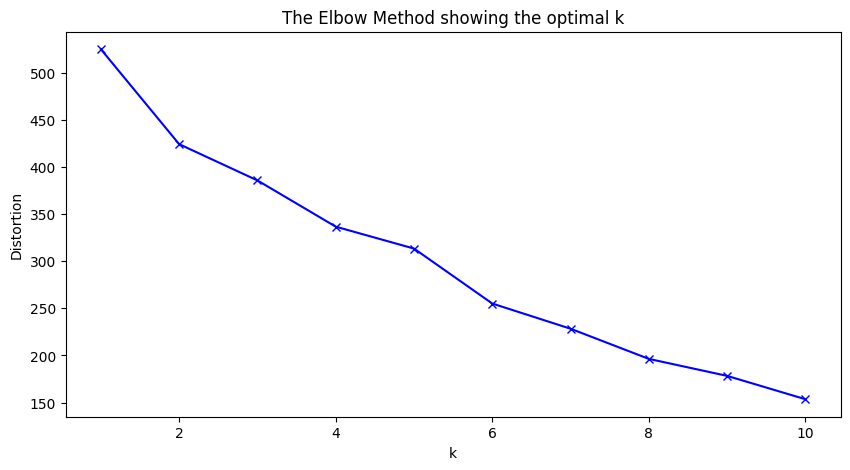

In [ ]:
elbow_method(lance_table)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
import pandas as pd

# Silhouette Method (silhouette_method function):
# Calculates the silhouette score for each data point
# The silhouette score measures how similar a point is to its own cluster compared to other clusters
# Ranges from -1 to 1, where:
# 1: Points are well-clustered
# 0: Points are on the boundary between clusters
# -1: Points are probably in the wrong cluster
# The optimal k is the one that maximizes the average silhouette score

def silhouette_method(lance_table, max_k=10):
    """Find optimal k using silhouette score"""
    X, _ = table_to_embeddings(lance_table)
    silhouette_scores = []
    K = range(2, max_k + 1)

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        score = silhouette_score(X, kmeanModel.labels_)
        silhouette_scores.append(score)

    plt.figure(figsize=(10, 5))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method showing the optimal k')
    plt.show()

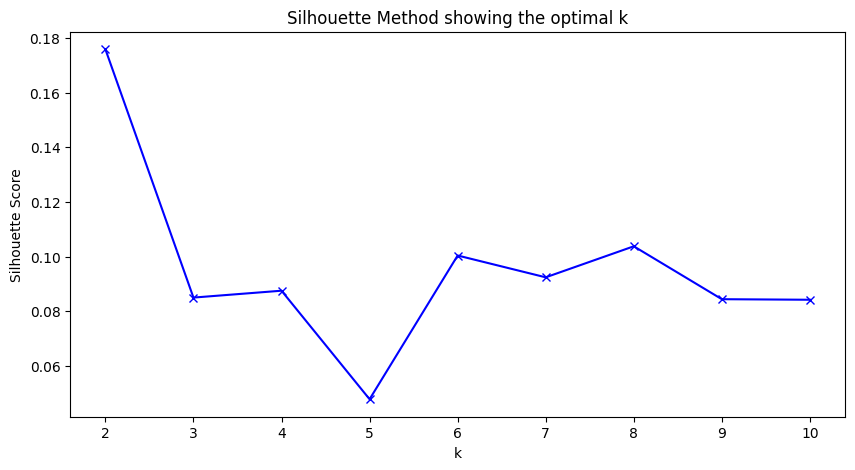

In [ ]:
silhouette_method(lance_table)

### [EXAMPLE CODE ABOVE]

Let's cluster the documents using KMeans, setting n_clusters to the value determined in the previous analysis.

In [ ]:
n_clusters_based_on_analysis = 2 # change this number to the optimal number of cluster determined
clusters_kmeans = perform_kmeans_clustering(
    lance_table,
    random_state=RANDOM_SEED,
    n_clusters=n_clusters_based_on_analysis
)
print_clusters(clusters_kmeans)


Cluster 0:
Node 0: In the quaint coastal town of Bellmare a curious ailment known as "Pigeon
Blessing" emerged seemingly overnight Initially townsfolk celebrated it
believing it to be a sign of good fortune—hence the unusual name However as
cases multiplied excitement turned to concernThe first recorded case was Evelyn
Carter an elderly woman known locally for feeding pigeons in Bellmare's central
plaza

Node 1: She began exhibiting peculiar yet benign symptoms an uncanny sense of direction
increased visual acuity and most curiously a compulsive need to coo softly
particularly during the twilight hours Neighbors joked kindly about Evelyn's
newfound "birdsong" but soon others experienced similar changesSymptoms
progressed gradually typically beginning with heightened senses and remarkable
navigation skills but eventually escalating into more pronounced behavioral
transformations

Node 2: Patients developed subtle feather-like patterns across their shoulders and upper
back visible only 

In [ ]:

def clusters_to_summaries_table(
    clusters,
    client,
    db_path
):

    summarizied_docs = []
    for i, cluster in enumerate(clusters):
        summary = summarize_cluster(i, client, cluster)
        summarizied_docs.append(
            {
                "text": summary,
                "children": [node.index for node in cluster],
                "id": i
            }
        )


    summaries_db_path = db_path
    shutil.rmtree(summaries_db_path, ignore_errors=True)

    summaries_db = lancedb.connect(summaries_db_path)

    summaries_lance_table = summaries_db.create_table(
        "transformer_docs",
        mode='overwrite',
        schema=BasicSchema
    )

    summaries_lance_table.add(
        summarizied_docs,
        on_bad_vectors='drop'
    )
    return summaries_lance_table

In [ ]:
summaries_lance_table_cluster_analysis = clusters_to_summaries_table(
    clusters=clusters_kmeans,
    client=client,
    db_path="/tmp/summaries_lancedb_cluster_analysis"
)

--------------------------------
Context to summarize for cluster 0:

Text to summarize: In the quaint coastal town of Bellmare a curious ailment known as "Pigeon
Blessing" emerged seemingly overnight Initially townsfolk celebrated it
believing it to be a sign of good fortune—hence the unusual name However as
cases multiplied excitement turned to concernThe first recorded case was Evelyn
Carter an elderly woman known locally for feeding pigeons in Bellmare's central
plaza She began exhibiting peculiar yet benign symptoms an uncanny sense of
direction increased visual acuity and most curiously a compulsive need to coo
softly particularly during the twilight hours Neighbors joked kindly about
Evelyn's newfound "birdsong" but soon others experienced similar changesSymptoms
progressed gradually typically beginning with heightened senses and remarkable
navigation skills but eventually escalating into more pronounced behavioral
transformations Patients developed subtle feather-like patterns 

We can now use these summaries to answer the original questions within the RAG pipeline:

In [ ]:
answer = answer_with_rag(
    QUESTION,
    client=client,
    model_name=ANSWERING_MODEL_NAME,
    make_context=prepare_context_maker_raptor(lance_table, summaries_lance_table_cluster_analysis),
    verbose=True,
)

--------------------------------
Retrieved summarized docs:

In Bellmare a coastal town "Pigeon Blessing" afflicted residents with a
mysterious ailment Initially it manifested as heightened senses and improved
navigation but eventually patients developed feather-like patterns and a
compulsion to coo softly The condition seemingly spreading rapidly sparked
concern as it progressed from benign to more pronounced

Retrieved original docs:

Human interactions with pigeons are diverse ranging from historical uses such as
messenger birds and food sources to contemporary roles as indicators of urban
ecological healthIn modern urban environments pigeons are sometimes viewed
negatively due to their abundance and potential as disease vectors However
ongoing research continues to reveal the complexity of pigeon biology and
underscores their importance within ecosystems and human cultures worldwide
Pigeons are rarely considered as a blessing but rather as a nuisanceThe Bless
spell counters the Cur